# Data description & Problem statement: 
This data set contains a total 5820 evaluation scores provided by students from Gazi University in Ankara (Turkey). There is a total of 28 course specific questions and additional 5 attributes. Please check the description at: http://archive.ics.uci.edu/ml/datasets/turkiye+student+evaluation

* Dataset is imbalanced. The data has 5820 rows and 33 variables.
* This is a classification problem. The classification goal is to predict number of times the student is taking this course: 0 (passed) and >0 (failed).


# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts 
   #  Model Training:
- Build an initial RF model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of RF model: Find the best RF model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best RF model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision
     
Finally, calculate the Feature Importance for the features 

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Turkiye student evaluation/turkiye-student-evaluation_generic.csv', sep=',') 


# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head()

,instr,class,nb.repeat,attendance,difficulty,Q1,Q2,Q3,Q4,Q5,...,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28
0,1,10,1,1,4,4,4,3,3,3,...,2,4,3,3,3,3,2,2,1,1
1,2,11,1,1,4,1,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,3,8,2,1,3,3,3,3,3,3,...,3,3,3,3,2,3,3,3,3,4
3,3,13,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,2,6,1,3,2,3,3,4,4,4,...,2,2,3,3,2,2,3,3,4,3


In [3]:
df['nb.repeat']=df['nb.repeat'].map({1: 0, 2: 1, 3: 1})

In [4]:
X=df[['attendance', 'difficulty', 'class', 'instr']]
y=df['nb.repeat']

In [5]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#for i in df.drop('nb.repeat', axis=1).columns:
#   encode_text_dummy(df, i)

encode_text_dummy(df, 'instr')

In [6]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Building the Initial Model & Cross-Validation: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=RandomForestClassifier(max_features=4, n_estimators=20, max_depth=15,  random_state=42, class_weight='balanced')
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.73210278 0.69155647 0.67677096 0.67791632 0.71430307] 

Accuracy: 0.70 (+/- 0.02)


In [25]:
# Grid-Search for the best model parameters: 

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#X_r, y_r =X_train, y_train
#X_r, y_r = SMOTE(kind='svm', random_state=42).fit_sample(X_train, y_train)
X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)


from sklearn.model_selection import GridSearchCV

param={'max_depth':[10, 20, 30], 'max_features':[2, 3, 4], 'n_estimators': [50]}

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param, 
                                                                 scoring='roc_auc', cv=kfold, n_jobs=-1)
grid_search.fit(X_r, y_r)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.252992,0.007072,0.043426,0.001793,10,2,50,"{'max_depth': 10, 'max_features': 2, 'n_estima...",0.799221,0.793202,0.809471,0.800631,0.006716,1,0.834870,0.834538,0.826956,0.832121,0.003655
1,0.340636,0.005359,0.050789,0.001696,10,3,50,"{'max_depth': 10, 'max_features': 3, 'n_estima...",0.798840,0.792365,0.808639,0.799948,0.006690,2,0.834952,0.834381,0.826817,0.832050,0.003708
2,0.382922,0.019211,0.041665,0.003041,10,4,50,"{'max_depth': 10, 'max_features': 4, 'n_estima...",0.798072,0.791878,0.808178,0.799376,0.006718,3,0.834899,0.834283,0.826884,0.832022,0.003642


In [19]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'max_depth': 10, 'max_features': 2, 'n_estimators': 50}
Best validation accuracy:  0.80 (+/- 0.01)
Test score:  0.75


Confusion matrix, without normalization
[[715 273]
 [ 56 120]]
Normalized confusion matrix
[[0.72 0.28]
 [0.32 0.68]]


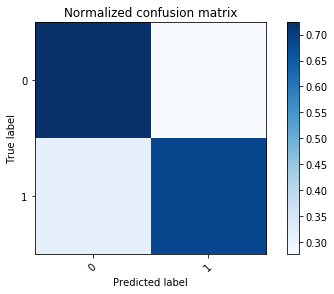

In [20]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [21]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.93      0.72      0.81       988
          1       0.31      0.68      0.42       176

avg / total       0.83      0.72      0.75      1164



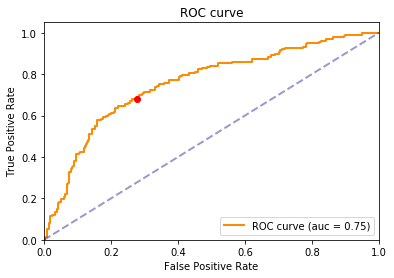

In [22]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

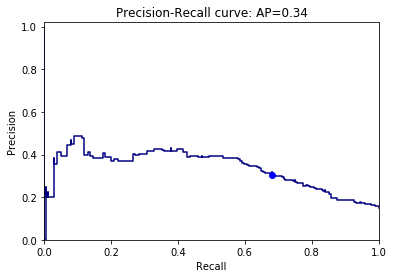

In [23]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(X_test)[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()

('attendance', 0.33087963909221957)
('difficulty', 0.29181617814369004)
('class', 0.24583231007459572)
('instr', 0.13147187268949465)


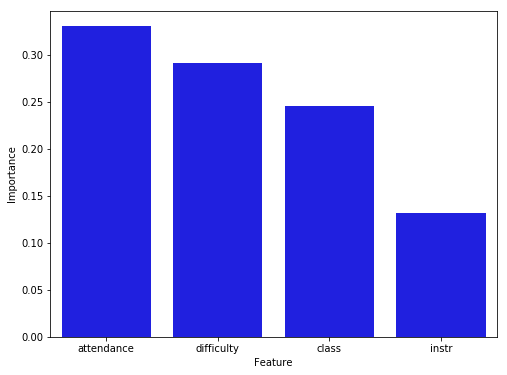

In [24]:
# Feature Importance:
im=RandomForestClassifier( max_depth= 20, max_features= 4, n_estimators= 50, random_state=42, class_weight="balanced").fit(X,y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(X.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(X.columns),columns=["Feature"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()